In [1]:
# Useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

backend = BasicAer.get_backend('unitary_simulator')

In [3]:
import sys

# $qfor f (n,b)$

In [4]:
def what_f(f):
    t = p = l = 0
    if f == 'X':
        t = pi
        p = 0
        l = pi
    elif f == 'Y':
        t = pi
        p = pi/2
        l = pi/2
    elif f == 'Z':
        t = 0
        p = 0
        l = pi
    elif f == 'H':
        t = pi/2
        p = 0
        l = pi
    elif f == 'S':
        t = 0
        p = 0
        l = pi/2
    elif f == 'Sdg':
        t = 0
        p = 0
        l = -pi/2
    elif f == 'T':
        t = 0
        p = 0
        l = pi/4
    elif f == 'Tdg':
        t = 0
        p = 0
        l = -pi/4
    # (theta, phi, lambda)
    return (t, p, l)   

# test
what_f('Z')

(0, 0, 3.141592653589793)

In [5]:
def what_n(n):
    if n == 1:
        l = ['q0', '1']
    elif n == 2:
        l = ['q1*q0','q1','q1+q0','1']
    elif n == 3:
        l = ['q2*q1*q0','q2*q1','q2*q1+q0','q2','q2+q1*q0', 'q2+q1','q2+q1+q0','1']
    elif n == 4:
        l = ['q3*q2*q1*q0','q3*q2*q1','q3*q2*q1+q0','q3*q2','q3*q2+q1*q0','q3*q2+q1','q3*q2+q1+q0','q3','q3+q2*q1*q0','q3+q2*q1','q3+q2*q1+q0','q3+q2','q3+q2+q1*q0','q3+q2+q1','q3+q2+q1+q0','1']
    else:
        l =[]
    rl =[x[::-1] for x in l]
    return rl[::-1]

#test
what_n(3)

['1', '0q+1q+2q', '1q+2q', '0q*1q+2q', '2q', '0q+1q*2q', '1q*2q', '0q*1q*2q']

In [6]:
def qfor_init(f,n):
    (t,p,l) = what_f(f)
    list_controls = what_n(n)
    print('OPENQASM 2.0;\ninclude "qelib1.inc";')

    if n <= 1:
        # the number of qubits
        qn=n
        print('qreg q[%d];'%(n+1))
        print('\n')
    else: 
        # the number of qubits
        qn = n + n
        print('qreg q[%d];'%qn)
    qfor(f,n,list_controls)

In [7]:
#writting pseudo qasm
def qfor(f, qn, lnn, d=0):
    # f   - function <str>
    # qn  - corresponds to the number of controls <int>
    # lnn - type of controls <lst>
    # d   - decomposition level <int>

    # defining the funtion f 
    (theta,phi,lambdaa) = what_f(f)
    # target
    tg = 0
    if lnn == []:
        return
    # g - gate we are implementing
    g=lnn.pop(0)
    # lg - instruction size
    lg = len(g)        
    try:
        aj = [d*3+2 for d in range(qn-1)]
        jj = aj + aj[::-1]
        j = jj[d]
        if g[j]=='*':
            # no need for decompostion
            if lg == 5 and d==0:
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn+1),tg))
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                d=0
            # first gate in the decomposition 
            elif d==0:
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                d+=1
                lnn=[g,*lnn]
            #last instruction
            elif d==qn+(qn-3):
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                d=0
            #reverse
            elif d>qn-2:
                #gates in decomposition
                print('ccx q[%d], q[%d], q[%d];'%((qn+(qn-1)-d),(qn*2-d+(qn-3)),(qn*2-d+(qn-2))))
                d+=1
                lnn=[g,*lnn]
            #other gates in decomposition
            else:
                #gates in decomposition
                print('ccx q[%d], q[%d], q[%d];'%((d+2),(qn+d),(qn+d+1)))
                #last gate in decomposition
                if d==qn-2:
                    print('cu3(%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn*2-1),tg))
                d+=1
                lnn=[g,*lnn]
            qfor(f,qn,lnn,d)
        elif g[j]=='+':
            # no need for decomposition
            if lg == 5 and d==0:
                print('x q[%d];'%(qn-1))
                print('x q[%d];'%qn)
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                print('x q[%d];'%(qn+1))
                print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn+1),tg))
                print('x q[%d];'%(qn+1))
                print('ccx q[%d], q[%d], q[%d];'%(qn,(qn-1),(qn+1)))
                print('x q[%d];'%(qn-1))
                print('x q[%d];'%qn)
                d=0
            # first gate in the decomposition 
            elif d==0:
                print('x q[%d];'%(tg+1))
                print('x q[%d];'%(tg+2))
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                print('x q[%d];'%(qn+1))
                d+=1
                lnn=[g,*lnn]
            #last instruction
            elif d==qn+(qn-3):
                print('x q[%d];'%(qn+1))
                print('ccx q[%d], q[%d], q[%d];'%((tg+1),(tg+2),(qn+1)))
                print('x q[%d];'%(tg+1))
                print('x q[%d];'%(tg+2))
                d=0
            #reverse
            elif d>qn-2:
                #gates in decomposition
                print('x q[%d];'%(qn*2+1-d))
                print('ccx q[%d], q[%d], q[%d];'%((qn+(qn-1)-d),(qn*2-d+(qn-3)),(qn*2-d+(qn-2))))
                print('x q[%d];'%(qn+2-d))
                print('x q[%d];'%(qn*2-d))
                d+=1
                lnn=[g,*lnn]
            #other gates in decomposition
            else:
                #gates in decomposition
                print('x q[%d];'%(d+2))
                print('x q[%d];'%(qn+d))
                print('ccx q[%d], q[%d], q[%d];'%((d+2),(qn+d),(qn+d+1)))
                print('x q[%d];'%(qn+d+1))
                #last gate in decomposition
                if d==qn-2:
                    print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,(qn*2-1),tg))
                d+=1
                lnn=[g,*lnn]
            qfor(f,qn,lnn,d)    
    except IndexError:
        # the initial case qn = 0 ( >= 0 )
        if g=='1':
            print('id q[%d];'%tg)
            #print('u3(%0.3f, %0.3f, %0.3f) q[%d];'%(theta,phi,lambdaa,tg))
        # the target only has one control 
        else:
            # control target
            print('cu3 (%0.3f, %0.3f, %0.3f) q[%d], q[%d];'%(theta,phi,lambdaa,qn,tg))
        qfor(f,qn,lnn) 

In [8]:
qfor_init('S', 3)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
id q[0];
x q[1];
x q[2];
ccx q[1], q[2], q[4];
x q[4];
x q[3];
x q[4];
ccx q[3], q[4], q[5];
x q[5];
cu3 (0.000, 0.000, 1.571) q[5], q[0];
x q[5];
ccx q[3], q[4], q[5];
x q[3];
x q[4];
x q[4];
ccx q[1], q[2], q[4];
x q[1];
x q[2];
x q[2];
x q[3];
ccx q[3], q[2], q[4];
x q[4];
cu3 (0.000, 0.000, 1.571) q[4], q[0];
x q[4];
ccx q[3], q[2], q[4];
x q[2];
x q[3];
ccx q[1], q[2], q[4];
x q[3];
x q[4];
ccx q[3], q[4], q[5];
x q[5];
cu3 (0.000, 0.000, 1.571) q[5], q[0];
x q[5];
ccx q[3], q[4], q[5];
x q[3];
x q[4];
ccx q[1], q[2], q[4];
cu3 (0.000, 0.000, 1.571) q[3], q[0];
x q[1];
x q[2];
ccx q[1], q[2], q[4];
x q[4];
ccx q[3], q[4], q[5];
cu3(0.000, 0.000, 1.571) q[5], q[0];
ccx q[3], q[4], q[5];
x q[4];
ccx q[1], q[2], q[4];
x q[1];
x q[2];
ccx q[3], q[2], q[4];
cu3 (0.000, 0.000, 1.571) q[4], q[0];
ccx q[3], q[2], q[4];
ccx q[1], q[2], q[4];
ccx q[3], q[4], q[5];
cu3(0.000, 0.000, 1.571) q[5], q[0];
ccx q[3], q[4], q[5];
ccx q[1], q[2], q[4];


In [9]:
%%capture cap --no-stderr

qfor_init('S', 3)

In [10]:

with open('output.qasm', 'w') as f:
    f.write(cap.stdout)

In [11]:
qc=QuantumCircuit.from_qasm_file('output.qasm')

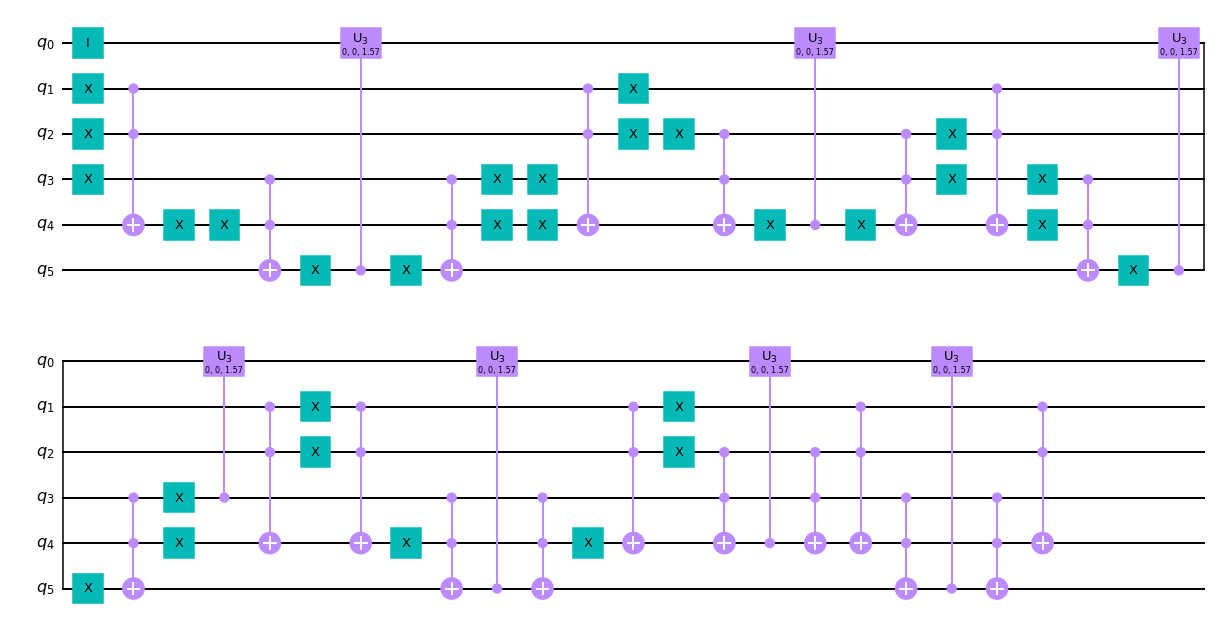

In [12]:
qc.draw(output='mpl')

In [13]:
job_matrix = execute(qc, backend)
matrix_res = job_matrix.result()
matrix = matrix_res.get_unitary(qc, decimals=3)

In [14]:
np.set_printoptions(threshold=sys.maxsize)
matrix

array([[ 1.00000000e+00-2.73785111e-15j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -1.68505982e-16+1.05049486e-15j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00

In [15]:
count = 0
final = [[]]
for i in matrix:
    if count<16:
        count2 = 0
        for j in i:
            if count2>=16:
                break
            else:
                j = round(j.real, 2) + round(j.imag, 2) * 1j
                if j==0j:
                    j=0
                elif j==(1+0j):
                    j=1
                elif j==(-1+0j):
                    j=-1
                final[count].append(j)
            count2+=1
        if count<15:
            final.append([])
    else:
        break
    count+=1

In [16]:
final

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1j, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, -1j, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1j, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1j]]